# CWT and DWT inverse

Sampling period: 0.010101010101010102 s
Sampling frequency: 98.99999999999999 Hz


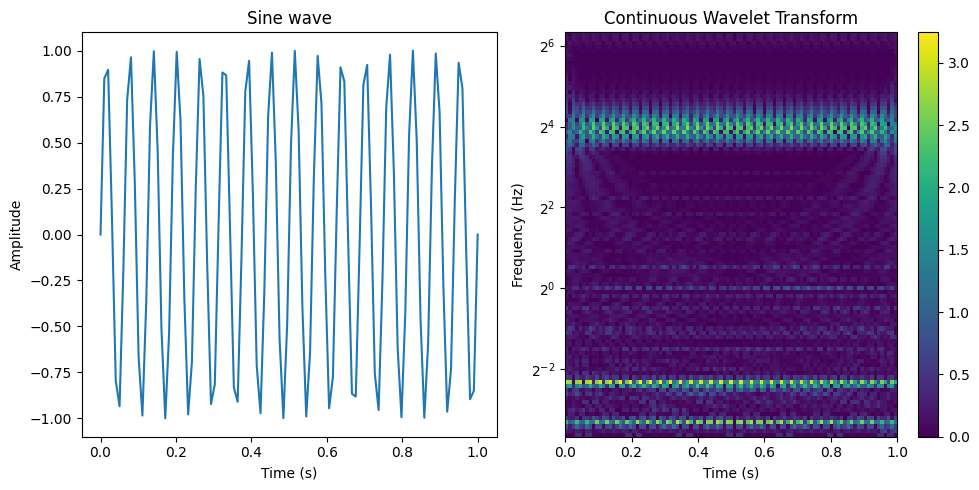

In [75]:
import pywt
import math
import numpy as np
import matplotlib.pyplot as plt

time = np.linspace(0, 1, 100)
freq = 16
sin = np.sin(2*np.pi*time*freq)  # 16 Hz sine wave

# Continuous Wavelet Transform
widths = np.geomspace(1, 1024, num=100)
sampling_period = np.diff(time).mean()
fs = 1/sampling_period
print(f"Sampling period: {sampling_period} s")
print(f"Sampling frequency: {fs} Hz")

coeffs_cwt_r, freqs_cwt = pywt.cwt(sin, widths, 'morl', sampling_period=sampling_period)
coeffs_cwt = np.abs(coeffs_cwt_r[:-1, :-1])

# adjust the figure size
plt.rcParams["figure.figsize"] = (10, 5)

# plot the singal
fig, axs = plt.subplots(1, 2)
axs[0].plot(time, sin)
axs[0].set_xlabel("Time (s)")
axs[0].set_ylabel("Amplitude")
axs[0].set_title("Sine wave")

# plot result using matplotlib's pcolormesh
pcm = axs[1].pcolormesh(time, freqs_cwt, coeffs_cwt)
axs[1].set_yscale("log", base=2)
axs[1].set_xlabel("Time (s)")
axs[1].set_ylabel("Frequency (Hz)")
axs[1].set_title("Continuous Wavelet Transform")
fig.colorbar(pcm, ax=axs[1])

fig.tight_layout()

In [ ]:
import pywt
import math

def plot_dwt_scaleogram(coeffs, x, fs, level, time=None):
    """
    Plot the scaleogram of the Discrete Wavelet Transform (DWT).

    Parameters:
    coeffs (list): List of DWT coefficients from pywt.wavedec.
    x (np.ndarray): Original signal.
    sample_freq (float): Sampling frequency of the signal.
    """
    # Compute the time axis
    if time is None:
        time = np.linspace(0, len(x) / fs, len(x))

        # Compute dyadic frequency bands
    freq_bands = [(fs / (2 ** (j + 1)), fs / (2 ** j)) for j in range(level)]
    freq_bands.append((0, freq_bands[-1][0]))  # Add cA frequency range (0 to lowest detail band)

    # Prepare the scaleogram
    scaleogram = []
    for i, coeff in enumerate(coeffs):
        factor = math.ceil(len(x)/len(coeff))
        # Upsample coefficients to match the original signal length
        upsampled = np.repeat(coeff, factor)[:len(x)]
        scaleogram.append(upsampled)
    scaleogram = np.array(scaleogram)
    scaleogram = scaleogram[:, :(len(x))-1]

    # Calculate the frequencies for each level (scales are powers of 2, so freqs are powers of 2)
    freqs_dwt = np.logspace(start=0, stop=level+2, num=level+2, base=2)
    print(freqs_dwt)

    # Plot the scaleogram
    plt.figure(figsize=(10, 6))
    plt.pcolormesh(time, freqs_dwt, np.abs(scaleogram), cmap='viridis')
    plt.colorbar(label='Amplitude')
    plt.title('DWT Scaleogram')
    plt.yscale('log', base=2)
    plt.xlabel('Time (s)')
    plt.ylabel('Decomposition Level')

    # Set y-ticks to show actual frequency ranges
    yticks = [np.mean(f) for f in freq_bands]
    yticklabels = [f"{f_low:.1f}-{f_high:.1f} Hz" for f_low, f_high in freq_bands]
    plt.yticks(yticks, yticklabels)

    plt.show()



[  1.           2.2449241    5.0396842   11.3137085   25.39841683
  57.01751796 128.        ]


/Users/alicia/Documents/Master/TFM/learnable-masks-explainability-time-series/.env/lib/python3.10/site-packages/pywt/_multilevel.py:43: UserWarning: Level value of 5 is too high: all coefficients will experience boundary effects.
  warnings.warn(


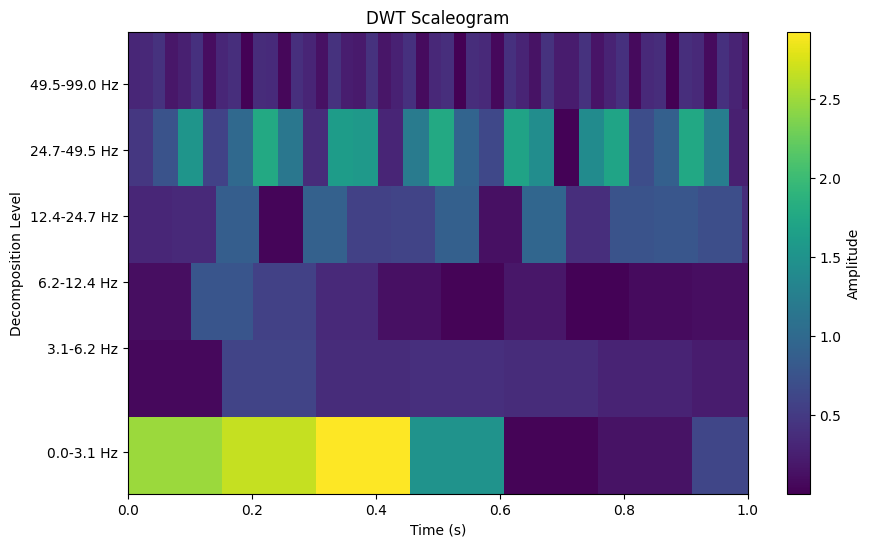

In [78]:
# Discrete Wavelet Transform
level = 5
wavelet = 'db3'
coeffs_dwt = pywt.wavedec(sin, wavelet, level=level)

plot_dwt_scaleogram(coeffs_dwt, sin, fs, level, time)

# duration = len(sin)

# # time = np.linspace(0, len(sin) / 100, len(sin))

# scaleogram = []
# for i, coeff in enumerate(coeffs_dwt):
#     factor = math.ceil(duration / len(coeff))
#     upsampled = np.repeat(coeff, factor)[:duration]
#     scaleogram.append(upsampled)

# scaleogram = np.array(scaleogram)
# scaleogram = scaleogram[:, :duration-1]
# # scaleogram = np.abs(scaleogram[:-1, :-1])

# # Calculate the frequencies for each level (scales are powers of 2, so freqs are powers of 2)
# freqs_dwt = np.logspace(start=0, stop=level+2, num=level+2, base=2)

# # adjust the figure size
# plt.rcParams["figure.figsize"] = (10, 5)

# # plot the singal
# fig, axs = plt.subplots(1, 2)
# axs[0].plot(time, sin)
# axs[0].set_xlabel("Time (s)")
# axs[0].set_ylabel("Amplitude")
# axs[0].set_title("Sine wave")

# # plot result using matplotlib's pcolormesh (image with annoted axes)
# pcm = axs[1].pcolormesh(time, freqs_dwt, np.abs(scaleogram))
# axs[1].set_yscale("log", base=2)
# axs[1].set_xlabel("Time (s)")
# axs[1].set_ylabel("Frequency (Hz)")
# axs[1].set_title("Discrete Wavelet Transform (Scaleogram)")
# fig.colorbar(pcm, ax=axs[1])

# fig.tight_layout()

/Users/alicia/Documents/Master/TFM/learnable-masks-explainability-time-series/.env/lib/python3.10/site-packages/pywt/_multilevel.py:43: UserWarning: Level value of 4 is too high: all coefficients will experience boundary effects.
  warnings.warn(


TypeError: Incompatible X, Y inputs to pcolormesh; see help(pcolormesh)

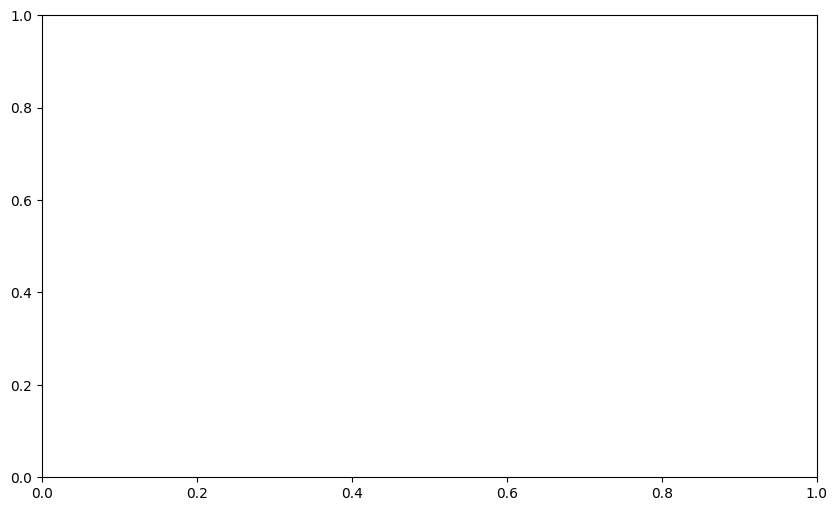

In [72]:
import numpy as np
import pywt
import matplotlib.pyplot as plt
from matplotlib.colors import Normalize

def plot_wavedec_scalogram(signal, fs, wavelet='db4', level=4):
    """
    Plots the scalogram of the wavelet decomposition using wavedec coefficients.

    Parameters:
    - signal: Input signal (1D numpy array)
    - fs: Sampling frequency in Hz
    - wavelet: Wavelet type (default: 'db4')
    - level: Number of decomposition levels (default: 4)
    """
    # Perform multi-level wavelet decomposition
    coeffs = pywt.wavedec(signal, wavelet, level=level)

    # Compute dyadic frequency bands
    freq_bands = [(fs / (2 ** (j + 1)), fs / (2 ** j)) for j in range(level)]
    freq_bands.append((0, freq_bands[-1][0]))  # Add cA frequency range (0 to lowest detail band)

    
    # Generate time axis
    time = np.linspace(0, len(signal) / fs, len(signal))

    # Prepare scalogram data (each level resized to match time resolution)
    # scalogram = []
    # for j, coef in enumerate(coeffs[::-1]):  # Reverse order to include cA last
    #     coef_resized = np.abs(np.interp(time, np.linspace(0, len(time), len(coef)), coef))
    #     scalogram.append(coef_resized)

    scalogram = []
    for i, coeff in enumerate(coeffs):
        factor = math.ceil(len(signal)/len(coeff))
        # Upsample coefficients to match the original signal length
        upsampled = np.repeat(coeff, factor)[:len(signal)]
        scalogram.append(upsampled)
    scalogram = np.array(scalogram)
    scalogram = scalogram[:, :(len(signal))-1]


    # Convert to array
    # scalogram = np.array(scalogram)

    # Plot scalogram
    plt.figure(figsize=(10, 6))
    plt.pcolormesh(time, freq_bands, np.abs(scalogram), cmap='viridis')

    # plt.imshow(scalogram, aspect='auto', extent=[0, time[-1], freq_bands[-1][0], freq_bands[0][1]],
    #           cmap='jet', origin='lower', norm=Normalize(vmin=0, vmax=np.max(scalogram)))

    # Label axes
    plt.xlabel("Time (s)")
    plt.ylabel("Frequency (Hz)")
    plt.colorbar(label="Magnitude")
    plt.title(f"Wavelet Scalogram ({wavelet}, {level} Levels)")
    
    # Set y-ticks to show actual frequency ranges
    yticks = [np.mean(f) for f in freq_bands]
    yticklabels = [f"{f_low:.1f}-{f_high:.1f} Hz" for f_low, f_high in freq_bands]
    plt.yticks(yticks, yticklabels)

    plt.show()

# Example usage
fs = 100  # Sampling frequency (Hz)
t = np.linspace(0, 1, fs, endpoint=False)  # 1-second time vector
signal = np.sin(2 * np.pi * 5 * t) # + np.sin(2 * np.pi * 12 * t)  # Example signal with 5 Hz & 12 Hz components

plot_wavedec_scalogram(signal, fs, wavelet='db4', level=4)


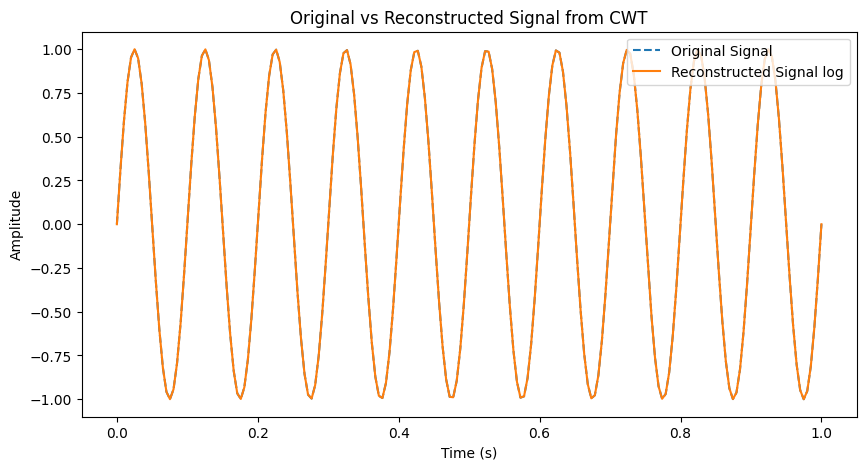

In [ ]:
# Inverse discrete wavelet transform
reconstructed_signal = pywt.waverec(coeffs_dwt, wavelet)

plt.figure(figsize=(10, 5))
plt.plot(time, sin, label='Original Signal', linestyle='dashed')
plt.plot(time, reconstructed_signal, label='Reconstructed Signal')
plt.legend(loc='upper right')
plt.xlabel("Time (s)")
plt.ylabel("Amplitude")
plt.title("Original vs Reconstructed Signal from DWT")
plt.show()

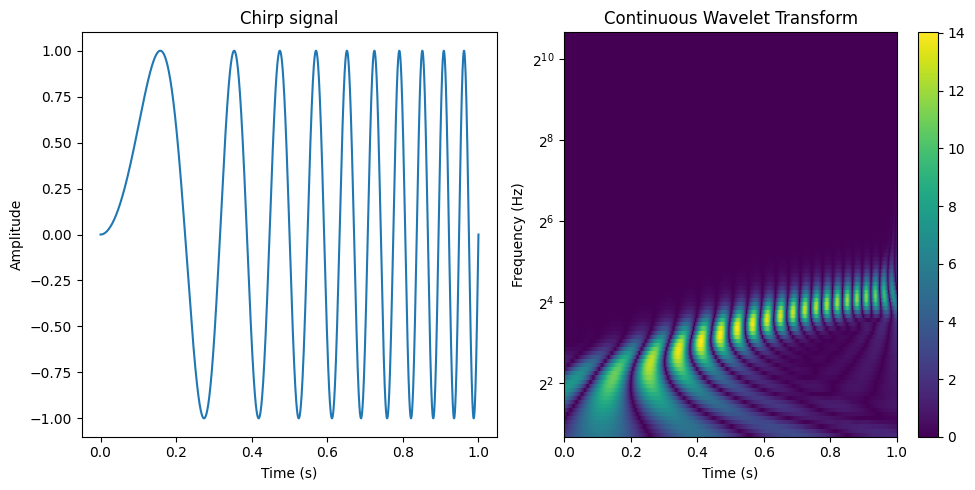

In [17]:
# generate a chirp signal
time = np.linspace(0, 1, 2000)
chirp = np.sin(2*np.pi*10*time**2)

# do the CWT morlet
widths_chirp = np.geomspace(1, 1024, num=100)
sampling_period = np.diff(time).mean()
coeffs_cwt_r, freqs_cwt = pywt.cwt(chirp, widths_chirp, 'morl', sampling_period=sampling_period)
coeffs_cwt = np.abs(coeffs_cwt_r[:-1, :-1])

# adjust the figure size
plt.rcParams["figure.figsize"] = (10, 5)

# plot the singal
fig, axs = plt.subplots(1, 2)
axs[0].plot(time, chirp)
axs[0].set_xlabel("Time (s)")
axs[0].set_ylabel("Amplitude")
axs[0].set_title("Chirp signal")

# plot result using matplotlib's pcolormesh
pcm = axs[1].pcolormesh(time, freqs_cwt, coeffs_cwt)
axs[1].set_yscale("log", base=2)
axs[1].set_xlabel("Time (s)")
axs[1].set_ylabel("Frequency (Hz)")
axs[1].set_title("Continuous Wavelet Transform")
fig.colorbar(pcm, ax=axs[1])

fig.tight_layout()


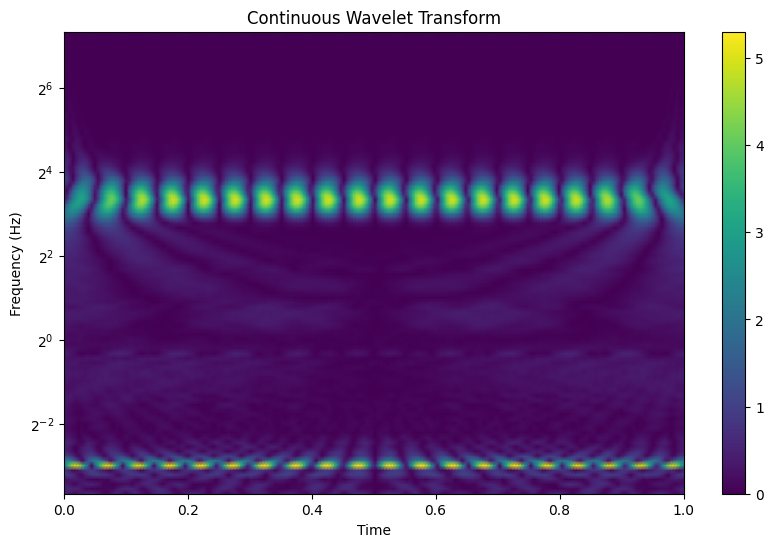

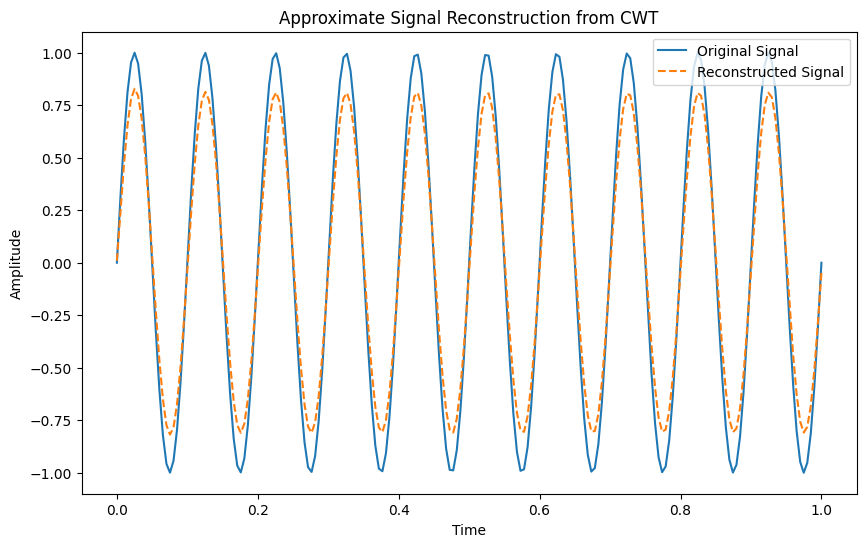

In [ ]:
import numpy as np
import pywt
import matplotlib.pyplot as plt

def icwt(cwtmatr, scales, C_psi=0.776, scale='uniform'):
    """
    Approximate inverse continuous wavelet transform.
    
    Parameters:
      cwtmatr : 2D array
          The CWT coefficient matrix (rows: scales, columns: time).
      scales : 1D array
          The scales corresponding to the rows of cwtmatr.
      C_psi : float, optional
          Admissibility constant for the wavelet (default is 0.776 for typical Morlet parameters).
          
    Returns:
      rec_signal : 1D array
          The reconstructed signal.
    """
    if scale == "uniform":    
        dj = scales[1] - scales[0]
    elif scale == "log":
        dj = (np.log(scales[-1]) - np.log(scales[0])) / (len(scales) - 1)
    
    # Sum over scales using the inversion formula:
    rec_signal = np.sum(np.real(cwtmatr) / np.sqrt(scales[:, None]), axis=0)
    
    # Multiply by the constant factors:
    # rec_signal *= (dt * np.sqrt(2 * np.pi) * dj) / C_psi
    rec_signal *= (dj) / C_psi
    
    return rec_signal

# Create a sample signal: a sine wave with a frequency of 10 Hz.
t = np.linspace(0, 1, 200)
freq = 10  # Hz
signal = np.sin(2 * np.pi * freq * t)

# Choose a complex Morlet wavelet; here using PyWavelets' cmor wavelet.
wavelet = 'morl'

widths = np.geomspace(1, 1024, num=100)

# Compute the Continuous Wavelet Transform (CWT)
sampling_period = t[1] - t[0] # sampling period

coef, freqs = pywt.cwt(signal, widths, wavelet, sampling_period)

# plot the CWT scaleogram
plt.figure(figsize=(10, 6))
plt.pcolormesh(t, freqs, np.abs(coef), shading='gouraud')
plt.colorbar()
plt.yscale('log', base=2)
plt.xlabel('Time')
plt.ylabel('Frequency (Hz)')
plt.title('Continuous Wavelet Transform')
plt.show()

# Reconstruct the signal using the logarithmic-scale inversion function.
rec_signal = icwt(coef, widths, sampling_period, C_psi=0.776, scale='log')

# Plot the original and reconstructed signals.
plt.figure(figsize=(10, 6))
plt.plot(t, signal, label='Original Signal')
plt.plot(t, rec_signal, label='Reconstructed Signal', linestyle='--')
plt.xlabel("Time")
plt.ylabel("Amplitude")
plt.title("Approximate Signal Reconstruction from CWT")
plt.legend(loc='upper right')
plt.show()

# do dft on original signal
n = len(signal)
frequencies = np.fft.fftfreq(n, d=sampling_period)
dft = np.fft.fft(signal)
dft = np.abs(dft)

# plot the DFT
plt.figure(figsize=(10, 6))
plt.plot(frequencies, dft)
plt.xlabel('Frequency (Hz)')
plt.ylabel('Amplitude')
plt.title('Discrete Fourier Transform')
plt.show()

# do dft on original signal
n = len(rec_signal)
frequencies = np.fft.fftfreq(n, d=sampling_period)
dft_r = np.fft.fft(rec_signal)
dft_r = np.abs(dft_r)

# plot the DFT
plt.figure(figsize=(10, 6))
plt.plot(frequencies, dft_r)
plt.xlabel('Frequency (Hz)')
plt.ylabel('Amplitude')
plt.title('Discrete Fourier Transform')
plt.show()


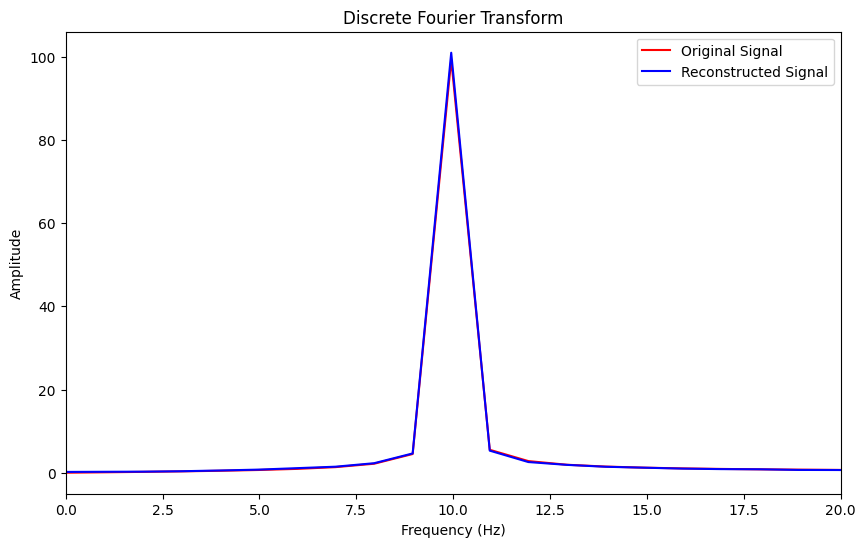

In [16]:
# do dft on original signal
n = len(signal)
frequencies = np.fft.rfftfreq(n, d=sampling_period)
dft = np.fft.rfft(signal)
dft = np.abs(dft)

# do dft on original signal
n = len(rec_signal)
frequencies = np.fft.rfftfreq(n, d=sampling_period)
dft_r = np.fft.rfft(rec_signal)
dft_r = np.abs(dft_r) * 1.25


# plot the DFT
plt.figure(figsize=(10, 6))
plt.plot(frequencies, dft, c='r', label='Original Signal')
plt.plot(frequencies, dft_r, c='b', label='Reconstructed Signal')
plt.legend(loc='upper right')
plt.xlabel('Frequency (Hz)')
plt.xlim(0, 20)
plt.ylabel('Amplitude')
plt.title('Discrete Fourier Transform')
plt.show()

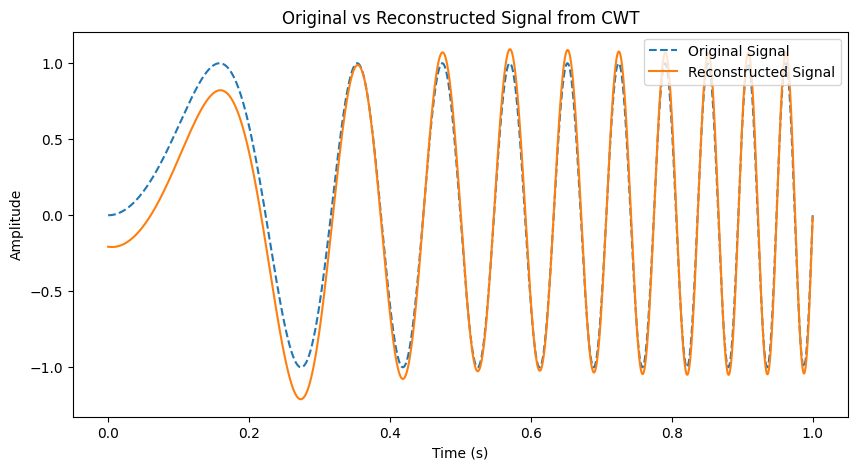

In [19]:
# reconstruct the signal using ICWT
reconstructed_signal_chirp = icwt(coeffs_cwt_r, widths_chirp, sampling_period, scale='log')

# plot original and reconstructed signals
plt.figure(figsize=(10, 5))
plt.plot(time, chirp, label='Original Signal', linestyle='dashed')
plt.plot(time, reconstructed_signal_chirp * 1.25, label='Reconstructed Signal')
plt.legend(loc='upper right')
plt.xlabel("Time (s)")
plt.ylabel("Amplitude")
plt.title("Original vs Reconstructed Signal from CWT")
plt.show()

500
500


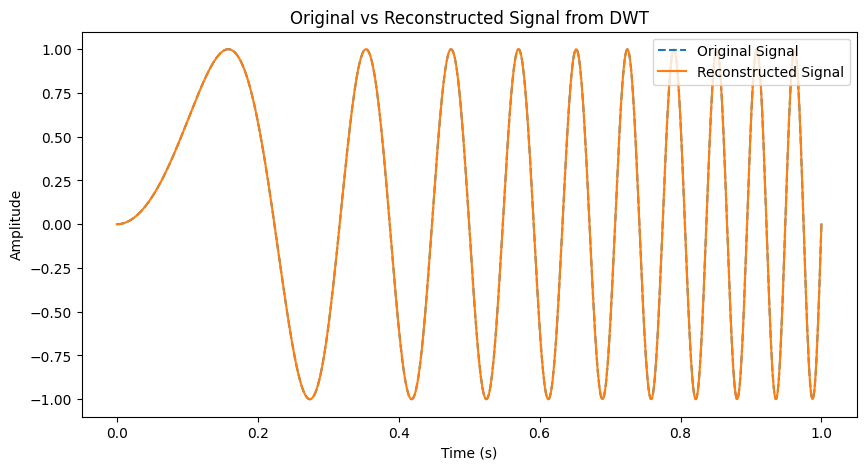

In [ ]:
# generate a chirp signal
time = np.linspace(0, 1, 100)
chirp = np.sin(2*np.pi*10*time**2)

# do the DWT daubenchies
level = 1
wavelet = 'db1'
coeffs_dwt_chirp = pywt.wavedec(chirp, wavelet, level=level)

print(len(coeffs_dwt_chirp[0]))
print(len(coeffs_dwt_chirp[1]))

# compute the inverse
rec_chirp = pywt.waverec(coeffs_dwt_chirp, wavelet)


# plot original and reconstructed signals
plt.figure(figsize=(10, 5))
plt.plot(time, chirp, label='Original Signal', linestyle='dashed')
plt.plot(time, rec_chirp, label='Reconstructed Signal')
plt.legend(loc='upper right')
plt.xlabel("Time (s)")
plt.ylabel("Amplitude")
plt.title("Original vs Reconstructed Signal from DWT")
plt.show()




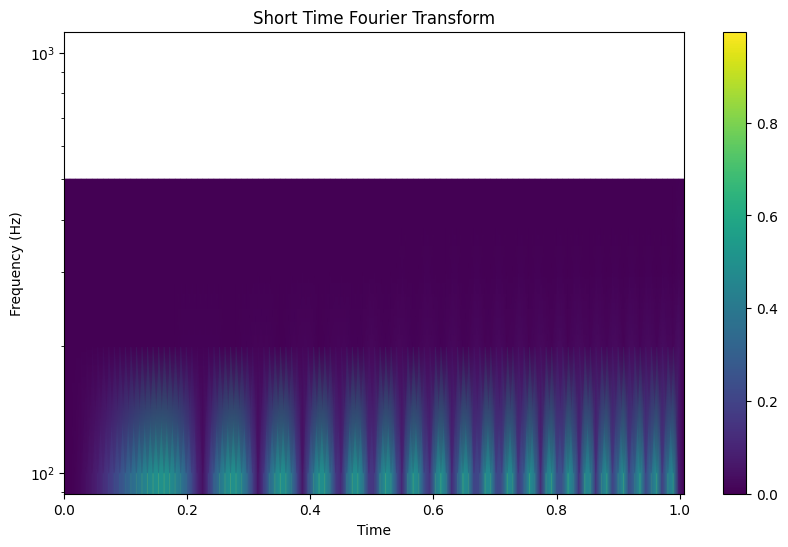

(6,)
(1008,)


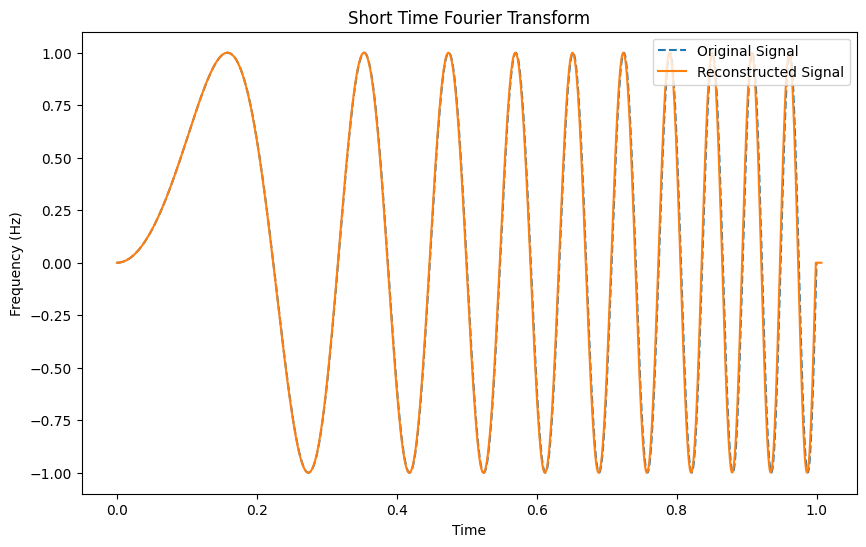

In [50]:
# implement short time fourirer transform
import numpy as np
import matplotlib.pyplot as plt
from scipy.signal import stft, istft

# do the STFT with a size of 
f, t, Zxx = stft(chirp, fs=1000, nperseg=10, noverlap=1)

# plot the stft spectogram
plt.figure(figsize=(10, 6))
plt.pcolormesh(t, f, np.abs(Zxx), shading='gouraud')
plt.colorbar()
plt.yscale('log')
plt.xlabel('Time')
plt.ylabel('Frequency (Hz)')
plt.title('Short Time Fourier Transform')
plt.show()

# compute the inversse STFT
t, rec_chirp_stft = istft(Zxx, fs=1000, nperseg=10, noverlap=1)

print(f.shape)
print(t.shape)


# plot the original vs reconstructed
plt.figure(figsize=(10, 6))
plt.plot(time, chirp, label='Original Signal', linestyle='dashed')
plt.plot(t, rec_chirp_stft, label='Reconstructed Signal')
plt.legend(loc='upper right')
plt.xlabel('Time')
plt.ylabel('Frequency (Hz)')
plt.title('Short Time Fourier Transform')
plt.show()

2
2
4
8
16
32
63
125
250
500


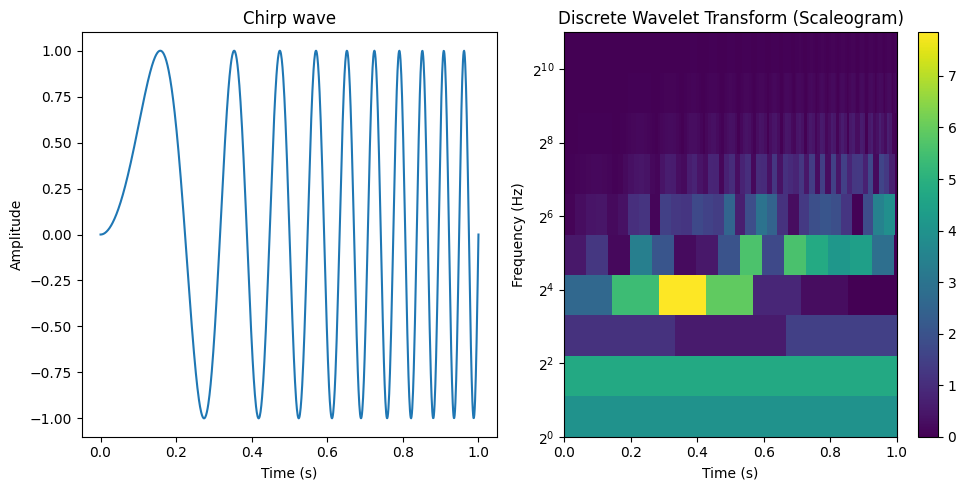

In [56]:
# Discrete Wavelet Transform
level = 9
wavelet = 'db1'
coeffs_dwt = pywt.wavedec(chirp, wavelet, level=level)

coeffs_ext = []
duration = len(chirp)

for i, coeff in enumerate(coeffs_dwt):
    print(len(coeff))
    coeff = np.abs(coeff[:-1])
    factor = duration / len(coeff)
    c_ext = [item for item in coeff for _ in range(int(factor))]
    coeffs_ext.append(c_ext)

# Create a 2D array for the scaleogram
scaleogram = np.zeros((level+1, duration))

# Fill the scaleogram with coefficients
for i, coeff in enumerate(coeffs_ext):        
    scaleogram[i, :len(coeff)] = coeff

scaleogram = scaleogram[:, :duration-1]

# Calculate the frequencies for each level (scales are powers of 2, so freqs are powers of 2)
freqs_dwt = np.logspace(start=0, stop=level+2, num=level+2, base=2)

# adjust the figure size
plt.rcParams["figure.figsize"] = (10, 5)

# plot the singal
fig, axs = plt.subplots(1, 2)
axs[0].plot(time, chirp)
axs[0].set_xlabel("Time (s)")
axs[0].set_ylabel("Amplitude")
axs[0].set_title("Chirp wave")

# plot result using matplotlib's pcolormesh (image with annoted axes)
pcm = axs[1].pcolormesh(time, freqs_dwt, scaleogram)
axs[1].set_yscale("log", base=2)
axs[1].set_xlabel("Time (s)")
axs[1].set_ylabel("Frequency (Hz)")
axs[1].set_title("Discrete Wavelet Transform (Scaleogram)")
fig.colorbar(pcm, ax=axs[1])

fig.tight_layout()